# 02 Model Building

### Table of Contents

### [1. Pre-Processing](#2-pre-processing)
- [1.1 Feature Engineering](#21-feature-engineering)
- [1.2 Data splitting](#22-data-splitting)
- [1.3 Optional PCA](#23-optional-pca)
- [1.4 Standardization](#24-standardization)
- [1.5 Data Leakage Check](#25-data-leakage-check)

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [54]:
# Load your data
df = pd.read_csv('../data/dataset_storage/final/all_matched_data.csv')
df

,close,metrics_long_short_ratio,open,low,volume,metrics_funding_rate,doge_close,sol_close,fng_fng,instrument_id,eth_close,ts_since_listing,high,metrics_open_interest,timestamp,btc_close
0,2.3721,0.000000,2.5000,2.2540,364165.9,0.0000,0.27947,245.08,52,0GUSDT-LINEAR,4577.98,1,2.5000,0.0,2025-09-18 07:30:00,117158.5
1,2.3825,0.000000,2.3721,2.3330,141187.8,0.0000,0.27973,244.63,52,0GUSDT-LINEAR,4572.66,2,2.4077,0.0,2025-09-18 07:45:00,117031.2
2,2.4558,0.000000,2.3825,2.2996,236802.1,0.0000,0.28108,245.48,52,0GUSDT-LINEAR,4580.81,3,2.5173,222419.5,2025-09-18 08:00:00,117190.1
3,2.4960,0.000000,2.4558,2.4196,260433.9,0.0000,0.28134,246.03,52,0GUSDT-LINEAR,4590.36,4,2.5990,222419.5,2025-09-18 08:15:00,117271.8
4,2.4229,0.000000,2.4960,2.3759,159007.6,0.0000,0.28081,246.39,52,0GUSDT-LINEAR,4592.27,5,2.5066,222419.5,2025-09-18 08:30:00,117153.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869780,3.9985,1.896871,3.9974,3.9860,44211.5,0.0001,0.12181,155.96,69,ZROUSDT-LINEAR,3393.40,2624,4.0031,4552538.4,2024-07-17 22:45:00,64230.8
869781,3.9845,1.896871,3.9985,3.9745,56726.6,0.0001,0.12160,155.40,69,ZROUSDT-LINEAR,3387.61,2625,3.9985,4552538.4,2024-07-17 23:00:00,64136.7
869782,4.0270,1.896871,3.9845,3.9832,128534.6,0.0001,0.12211,155.97,69,ZROUSDT-LINEAR,3400.17,2626,4.0394,4552538.4,2024-07-17 23:15:00,64261.2
869783,4.0156,1.896871,4.0270,4.0109,71288.7,0.0001,0.12206,155.79,69,ZROUSDT-LINEAR,3395.61,2627,4.0348,4552538.4,2024-07-17 23:30:00,64190.9


### 1.1 Feature Engineering

In [55]:
X = df[["open", "high", "low", "close", "volume", "metrics_long_short_ratio", "metrics_funding_rate", "metrics_open_interest", "btc_close", "doge_close", "sol_close", "fng_fng", "eth_close", "ts_since_listing"]]
X

,open,high,low,close,volume,metrics_long_short_ratio,metrics_funding_rate,metrics_open_interest,btc_close,doge_close,sol_close,fng_fng,eth_close,ts_since_listing
0,2.5000,2.5000,2.2540,2.3721,364165.9,0.000000,0.0000,0.0,117158.5,0.27947,245.08,52,4577.98,1
1,2.3721,2.4077,2.3330,2.3825,141187.8,0.000000,0.0000,0.0,117031.2,0.27973,244.63,52,4572.66,2
2,2.3825,2.5173,2.2996,2.4558,236802.1,0.000000,0.0000,222419.5,117190.1,0.28108,245.48,52,4580.81,3
3,2.4558,2.5990,2.4196,2.4960,260433.9,0.000000,0.0000,222419.5,117271.8,0.28134,246.03,52,4590.36,4
4,2.4960,2.5066,2.3759,2.4229,159007.6,0.000000,0.0000,222419.5,117153.5,0.28081,246.39,52,4592.27,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869780,3.9974,4.0031,3.9860,3.9985,44211.5,1.896871,0.0001,4552538.4,64230.8,0.12181,155.96,69,3393.40,2624
869781,3.9985,3.9985,3.9745,3.9845,56726.6,1.896871,0.0001,4552538.4,64136.7,0.12160,155.40,69,3387.61,2625
869782,3.9845,4.0394,3.9832,4.0270,128534.6,1.896871,0.0001,4552538.4,64261.2,0.12211,155.97,69,3400.17,2626
869783,4.0270,4.0348,4.0109,4.0156,71288.7,1.896871,0.0001,4552538.4,64190.9,0.12206,155.79,69,3395.61,2627


## Model 1 (Binary Classifier)  
#### Predict after the first day if the coin will keep dropping and never climb above the first day or not  
  
X: First day of data with all features  
Y: Will price be above the highest price from day 1 ever again throughout all data (Yes/No)

### 1.2 Define Target

In [56]:
def first_day_breakout_label(
    df: pd.DataFrame,
    existing: dict | None = None,
    instrument_col: str = "instrument_id",
    ts_col: str = "timestamp",
    high_col: str = "high",
) -> dict:

    if existing is None:
        existing = {}
    else:
        existing = dict(existing)  # copy so we don't mutate caller's dict

    d = df[[instrument_col, ts_col, high_col]].copy()
    d[ts_col] = pd.to_datetime(d[ts_col], errors="coerce")
    d = d.dropna(subset=[instrument_col, ts_col, high_col]).sort_values([instrument_col, ts_col])

    for inst, g in d.groupby(instrument_col, sort=False):
        t0 = g[ts_col].iloc[0]
        t1 = t0 + pd.Timedelta(days=1)

        first_day = g[(g[ts_col] >= t0) & (g[ts_col] <= t1)]
        if first_day.empty:
            # If somehow no data in first day window, default to 1 (no breakout detected)
            existing[inst] = 1
            continue

        max_high_1d = first_day[high_col].max()

        after = g[g[ts_col] > t1]
        breakout = (after[high_col] > max_high_1d).any() if not after.empty else False

        existing[inst] = 0 if breakout else 1

    return existing

first_day_breakout_label(df)

{'0GUSDT-LINEAR': 0,
 '1000000BABYDOGEUSDT-LINEAR': 1,
 '1000000CHEEMSUSDT-LINEAR': 0,
 '1000000MOGUSDT-LINEAR': 0,
 '10000ELONUSDT-LINEAR': 1,
 '10000QUBICUSDT-LINEAR': 1,
 '1000CATUSDT-LINEAR': 0,
 '1000NEIROCTOUSDT-LINEAR': 0,
 '1000TAGUSDT-LINEAR': 0,
 '1000TOSHIUSDT-LINEAR': 1,
 '1000TURBOUSDT-LINEAR': 0,
 '1000XUSDT-LINEAR': 0,
 '2ZUSDT-LINEAR': 1,
 '4USDT-LINEAR': 1,
 'A2ZUSDT-LINEAR': 0,
 'ACTUSDT-LINEAR': 0,
 'ACXUSDT-LINEAR': 1,
 'AEROUSDT-LINEAR': 0,
 'AEVOUSDT-LINEAR': 0,
 'AINUSDT-LINEAR': 1,
 'AIOUSDT-LINEAR': 0,
 'AIOZUSDT-LINEAR': 1,
 'AIXBTUSDT-LINEAR': 0,
 'AKEUSDT-LINEAR': 1,
 'AKTUSDT-LINEAR': 0,
 'ALCHUSDT-LINEAR': 1,
 'ALEOUSDT-LINEAR': 0,
 'ALLOUSDT-LINEAR': 1,
 'ALPINEUSDT-LINEAR': 0,
 'ALTUSDT-LINEAR': 0,
 'ALUUSDT-LINEAR': 1,
 'ANIMEUSDT-LINEAR': 1,
 'APEXUSDT-LINEAR': 1,
 'APRUSDT-LINEAR': 1,
 'ARCUSDT-LINEAR': 0,
 'ARIAUSDT-LINEAR': 0,
 'ASPUSDT-LINEAR': 1,
 'ASRUSDT-LINEAR': 1,
 'ASTERUSDT-LINEAR': 0,
 'ATHUSDT-LINEAR': 1,
 'ATUSDT-LINEAR': 0,
 'AUSDT-LINEA

In [57]:
labels = first_day_breakout_label(df)
bearishs = [k for k, v in labels.items() if v == 1]
print(f"{len(bearishs)} out of {len(labels.items())} never break their first day high")

151 out of 335 never break their first day high


### 1.3 Data Splitting

In [58]:
def first_day_breakout_label(df):
    labels = {}
    d = df[['instrument_id', 'timestamp', 'high']].copy()
    d['timestamp'] = pd.to_datetime(d['timestamp'], errors='coerce')
    d = d.dropna(subset=['instrument_id', 'timestamp', 'high']).sort_values(['instrument_id', 'timestamp'])
    
    for inst, g in d.groupby('instrument_id', sort=False):
        t0 = g['timestamp'].iloc[0]
        t1 = t0 + pd.Timedelta(days=1)
        
        first_day = g[(g['timestamp'] >= t0) & (g['timestamp'] <= t1)]
        if first_day.empty:
            labels[inst] = 1
            continue
        
        max_high_1d = first_day['high'].max()
        after = g[g['timestamp'] > t1]
        breakout = (after['high'] > max_high_1d).any() if not after.empty else False
        labels[inst] = 0 if breakout else 1
    
    return labels

labels_dict = first_day_breakout_label(df)
print(f"Labels created: {len(labels_dict)} coins")
print(f"Breakout (0): {sum(1 for v in labels_dict.values() if v == 0)}")
print(f"No breakout (1): {sum(1 for v in labels_dict.values() if v == 1)}")



Labels created: 335 coins
Breakout (0): 184
No breakout (1): 151


In [59]:
df_work = df.copy()
df_work['timestamp'] = pd.to_datetime(df_work['timestamp'], errors='coerce')
combined = pd.concat([df_work[['instrument_id', 'timestamp']], X], axis=1)
combined = combined.sort_values(['instrument_id', 'timestamp'])

first_day_data = []
for inst, g in combined.groupby('instrument_id', sort=False):
    t0 = g['timestamp'].iloc[0]
    t1 = t0 + pd.Timedelta(days=1)
    first_day = g[(g['timestamp'] >= t0) & (g['timestamp'] <= t1)]
    
    if first_day.empty:
        continue
    
    agg_dict = {'instrument_id': inst}
    for col in X.columns:
        if first_day[col].dtype in [np.float64, np.float32, np.int64, np.int32]:
            agg_dict[f'{col}_last'] = first_day[col].iloc[-1]
            agg_dict[f'{col}_last10_mean'] = first_day[col].loc[-10:-1].mean()

    
    first_day_data.append(agg_dict)

first_day_df = pd.DataFrame(first_day_data)
print(f"\nFirst day aggregated shape: {first_day_df.shape}")


First day aggregated shape: (335, 29)


In [60]:
first_day_df['target'] = first_day_df['instrument_id'].map(labels_dict)
first_day_df = first_day_df.dropna(subset=['target'])

feature_cols = [col for col in first_day_df.columns if col not in ['instrument_id', 'target']]
X_model = first_day_df[feature_cols]
y_model = first_day_df['target'].astype(int)

print(f"Final dataset: {X_model.shape[0]} coins, {X_model.shape[1]} features")

unique_instruments = first_day_df['instrument_id'].unique()
train_instruments, test_instruments = train_test_split(
    unique_instruments, 
    test_size=0.3, 
    random_state=42,
    stratify=first_day_df.groupby('instrument_id')['target'].first()
)

train_mask = first_day_df['instrument_id'].isin(train_instruments)
test_mask = first_day_df['instrument_id'].isin(test_instruments)

X_train = X_model[train_mask]
X_test = X_model[test_mask]
y_train = y_model[train_mask]
y_test = y_model[test_mask]

print(f"\nTrain: {len(X_train)} coins | Test: {len(X_test)} coins")
model = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1
)

model.fit(X_train, y_train)

Final dataset: 335 coins, 28 features

Train: 234 coins | Test: 101 coins


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,6
,learning_rate,0.05
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [61]:
y_pred_test = model.predict(X_test)
y_pred_proba_test = model.predict_proba(X_test)[:, 1]

test_acc = accuracy_score(y_test, y_pred_test)
test_auc = roc_auc_score(y_test, y_pred_proba_test)

print("\n" + "="*60)
print("RESULTS")
print("="*60)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC-ROC:  {test_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, target_names=['Breakout', 'No Breakout']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_test)
print(f"              Predicted")
print(f"            Breakout  No Break")
print(f"Breakout       {cm[0,0]:4d}     {cm[0,1]:4d}")
print(f"No Break       {cm[1,0]:4d}     {cm[1,1]:4d}")

print("\nTop 15 Features:")
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

for idx, row in feature_importance.head(15).iterrows():
    print(f"{row['feature']:40s}: {row['importance']:8.1f}")

model.booster_.save_model("lgbm_model.txt")


RESULTS
Test Accuracy: 0.6139
Test AUC-ROC:  0.5613

Classification Report:
              precision    recall  f1-score   support

    Breakout       0.64      0.67      0.65        55
 No Breakout       0.58      0.54      0.56        46

    accuracy                           0.61       101
   macro avg       0.61      0.61      0.61       101
weighted avg       0.61      0.61      0.61       101


Confusion Matrix:
              Predicted
            Breakout  No Break
Breakout         37       18
No Break         21       25

Top 15 Features:
eth_close_last                          :    118.0
sol_close_last                          :    113.0
metrics_open_interest_last              :     91.0
open_last                               :     75.0
doge_close_last                         :     75.0
fng_fng_last                            :     75.0
volume_last                             :     70.0
btc_close_last                          :     48.0
low_last                              

## Model 2 (Multiclass Classifier) ``[tbd]``
#### Predict Lows of coin
  
X: All X features up to point + distance entry-high  
Y: Will price drop down 1:1, 2:1, 3:1, 5:1?

## Backtest Implementation

BACKTEST: SHORT NEW LISTINGS
Starting Equity: $10,000.00
Test Coins: 101
Predicted Shorts: 46
Coins with entry times: 101
Timerange: 2024-01-03 10:45:00 to 2025-12-21 12:45:00
Risk per Trade: 5.0%
Max Positions: 20
  ENTRY: MBOXUSDT-LINEAR @ $0.3290 | SL: $0.3692 | Risk: $500.00 | Size: $4095.22 | Equity: $10000.00
  ENTRY: TAOUSDT-LINEAR @ $436.5400 | SL: $478.4780 | Risk: $500.00 | Size: $5204.59 | Equity: $10000.00
  EXIT: TAOUSDT-LINEAR @ $478.4780 | Stop Loss | P&L: $-500.00 (-9.61%) | New Equity: $9500.00
  EXIT: MBOXUSDT-LINEAR @ $0.3692 | Stop Loss | P&L: $-500.00 (-12.21%) | New Equity: $9000.00
  ENTRY: ETHFIUSDT-LINEAR @ $3.0060 | SL: $3.5616 | Risk: $450.00 | Size: $2434.85 | Equity: $9000.00
  EXIT: ETHFIUSDT-LINEAR @ $3.5616 | Stop Loss | P&L: $-450.00 (-18.48%) | New Equity: $8550.00
  ENTRY: MERLUSDT-LINEAR @ $1.1034 | SL: $1.3858 | Risk: $427.50 | Size: $1670.43 | Equity: $8550.00
  EXIT: MERLUSDT-LINEAR @ $0.4428 | Data Ended | P&L: $1000.08 (59.87%) | New Equity: $95

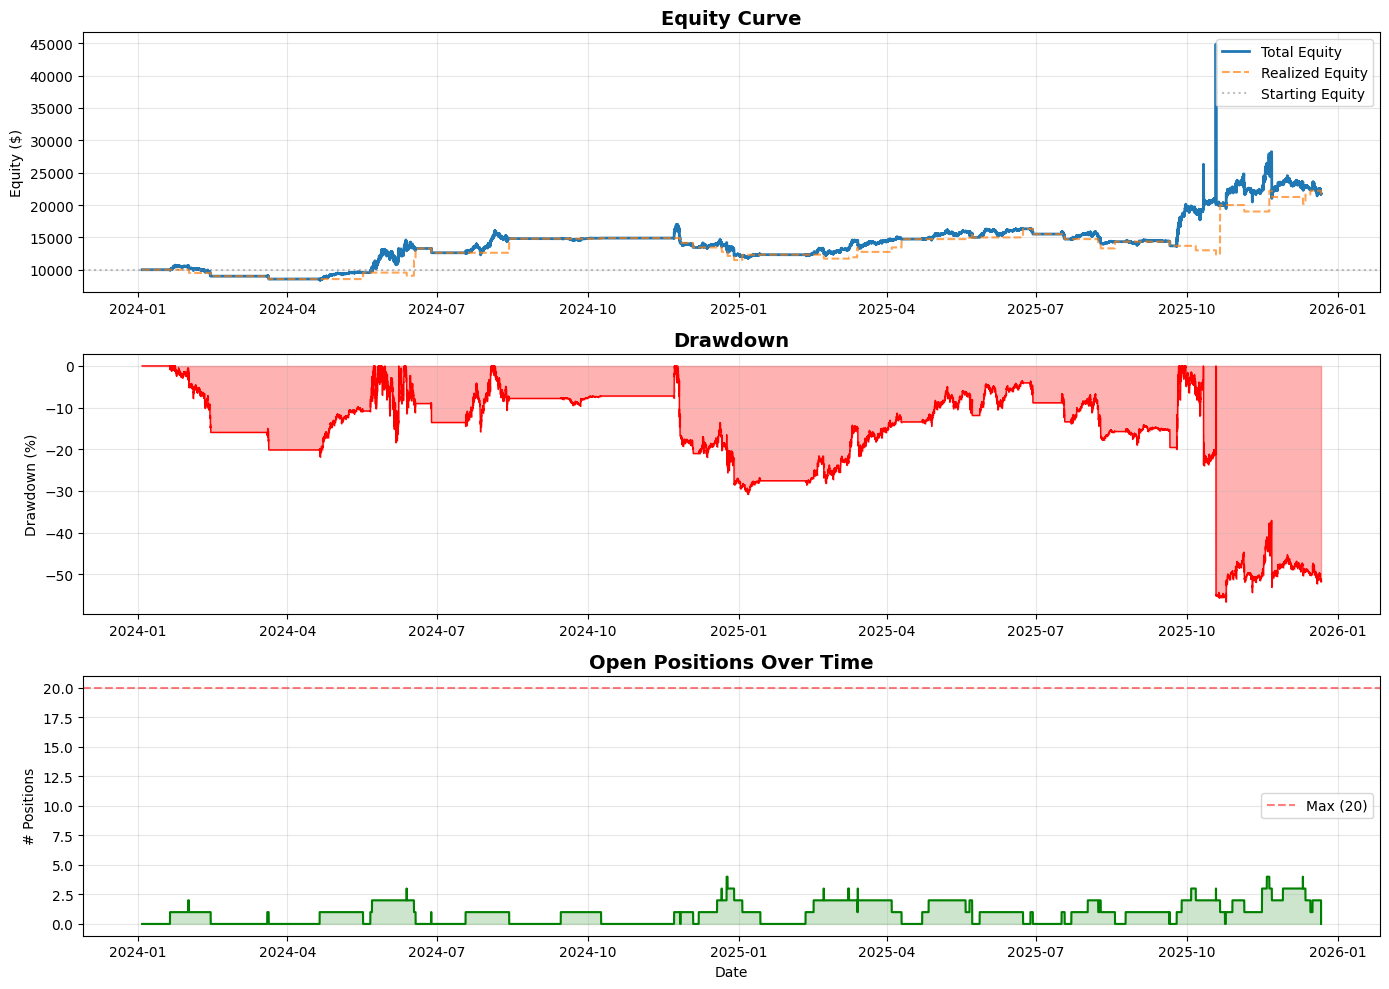


Final Return: 116.63%


In [ ]:
# NOTE Vibe coded - tst properly

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class ShortBacktest:
    def __init__(self, df, X, model, test_instruments, 
                 starting_equity=10000, risk_per_trade=0.05, max_positions=20):
        self.df = df[df['instrument_id'].isin(test_instruments)].copy()
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
        self.df = self.df.sort_values('timestamp').reset_index(drop=True)
        
        self.X = X
        self.model = model
        self.test_instruments = test_instruments
        self.starting_equity = starting_equity
        self.risk_per_trade = risk_per_trade
        self.max_positions = max_positions
        
        self.equity = starting_equity
        self.open_positions = {}
        self.closed_trades = []
        self.equity_curve = []
        
        # Get first day data and last timestamps per coin
        self.first_day_highs = {}
        self.listing_times = {}
        self.entry_times = {}  # NEW: When we can actually enter (1 day after listing)
        self.last_timestamps = {}
        self.predictions = {}
        
        self._prepare_data()
    
    def _prepare_data(self):
        """Get first day highs, listing times, and predictions"""
        combined = pd.concat([self.df[['instrument_id', 'timestamp']], 
                             self.X.loc[self.df.index]], axis=1)
        
        for inst in self.test_instruments:
            inst_data = self.df[self.df['instrument_id'] == inst].sort_values('timestamp')
            if len(inst_data) == 0:
                continue
            
            t0 = inst_data['timestamp'].iloc[0]
            t1 = t0 + pd.Timedelta(days=1)
            first_day = inst_data[(inst_data['timestamp'] >= t0) & 
                                 (inst_data['timestamp'] <= t1)]
            
            if not first_day.empty:
                self.first_day_highs[inst] = first_day['high'].max()
                self.listing_times[inst] = t0
                self.last_timestamps[inst] = inst_data['timestamp'].max()
                
                # NEW: Find the first timestamp AFTER the first day
                after_first_day = inst_data[inst_data['timestamp'] > t1]
                if not after_first_day.empty:
                    self.entry_times[inst] = after_first_day['timestamp'].iloc[0]
                
                # Get prediction
                first_day_combined = combined[(combined['instrument_id'] == inst) & 
                                             (combined['timestamp'] >= t0) & 
                                             (combined['timestamp'] <= t1)]
                
                if not first_day_combined.empty:
                    features = {}
                    for col in self.X.columns:
                        if first_day_combined[col].dtype in [np.float64, np.float32, np.int64, np.int32]:
                            features[f'{col}_last'] = first_day_combined[col].iloc[-1]
                            features[f'{col}_last10_mean'] = first_day_combined[col].iloc[-10:].mean()
                    
                    X_pred = pd.DataFrame([features])
                    self.predictions[inst] = self.model.predict(X_pred)[0]
    
    def _enter_position(self, inst, entry_price, entry_time):
        """Enter a short position"""
        stop_loss = self.first_day_highs[inst] * 1.001
        sl_distance_pct = (stop_loss - entry_price) / entry_price
        
        if sl_distance_pct <= 0:
            print(f"  SKIP: {inst} - Entry ${entry_price:.4f} already above SL ${stop_loss:.4f}")
            return False
        
        equity_risked = self.equity * self.risk_per_trade
        position_size = equity_risked / sl_distance_pct
        
        self.open_positions[inst] = {
            'entry_price': entry_price,
            'entry_time': entry_time,
            'entry_equity': self.equity,
            'stop_loss': stop_loss,
            'position_size': position_size,
            'equity_risked': equity_risked,
        }
        print(f"  ENTRY: {inst} @ ${entry_price:.4f} | SL: ${stop_loss:.4f} | Risk: ${equity_risked:.2f} | Size: ${position_size:.2f} | Equity: ${self.equity:.2f}")
        return True
    
    def _close_position(self, inst, exit_price, exit_time, reason):
        """Close a position and record P&L"""
        if inst not in self.open_positions:
            return 0
            
        pos = self.open_positions[inst]
        
        # Calculate P&L for shorts: profit when price goes down
        price_change_pct = (pos['entry_price'] - exit_price) / pos['entry_price']
        pnl = pos['position_size'] * price_change_pct
        
        self.equity += pnl
        
        print(f"  EXIT: {inst} @ ${exit_price:.4f} | {reason} | P&L: ${pnl:.2f} ({price_change_pct*100:.2f}%) | New Equity: ${self.equity:.2f}")
        
        self.closed_trades.append({
            'instrument': inst,
            'entry_time': pos['entry_time'],
            'entry_price': pos['entry_price'],
            'entry_equity': pos['entry_equity'],
            'exit_time': exit_time,
            'exit_price': exit_price,
            'stop_loss': pos['stop_loss'],
            'exit_reason': reason,
            'position_size': pos['position_size'],
            'pnl': pnl,
            'pnl_pct': (pnl / pos['equity_risked']) * 100
        })
        
        del self.open_positions[inst]
        return pnl
    
    def run(self):
        """Run the backtest"""
        timestamps = sorted(self.df['timestamp'].unique())
        
        print("="*80)
        print("BACKTEST: SHORT NEW LISTINGS")
        print("="*80)
        print(f"Starting Equity: ${self.starting_equity:,.2f}")
        print(f"Test Coins: {len(self.test_instruments)}")
        print(f"Predicted Shorts: {sum(1 for v in self.predictions.values() if v == 1)}")
        print(f"Coins with entry times: {len(self.entry_times)}")
        print(f"Timerange: {timestamps[0]} to {timestamps[-1]}")
        print(f"Risk per Trade: {self.risk_per_trade*100}%")
        print(f"Max Positions: {self.max_positions}")
        print("="*80)
        
        for current_time in timestamps:
            current_data = self.df[self.df['timestamp'] == current_time]
            
            # 1. Check existing positions for stops/exits
            for inst in list(self.open_positions.keys()):
                pos = self.open_positions[inst]
                inst_data = current_data[current_data['instrument_id'] == inst]
                
                # Check if this is the last timestamp for this coin
                if current_time == self.last_timestamps.get(inst):
                    if not inst_data.empty:
                        current_close = inst_data['close'].iloc[0]
                        current_high = inst_data['high'].iloc[0]
                        
                        # Check stop loss first
                        if current_high >= pos['stop_loss']:
                            self._close_position(inst, pos['stop_loss'], current_time, 'Stop Loss')
                        # Check month end
                        elif current_time >= pos['entry_time'] + pd.Timedelta(days=30):
                            self._close_position(inst, current_close, current_time, 'Month End')
                        else:
                            self._close_position(inst, current_close, current_time, 'Data Ended')
                    continue
                
                # Check if coin's data has completely ended
                if current_time > self.last_timestamps.get(inst, current_time):
                    continue
                
                if inst_data.empty:
                    continue
                
                current_high = inst_data['high'].iloc[0]
                current_close = inst_data['close'].iloc[0]
                
                # Check stop loss
                if current_high >= pos['stop_loss']:
                    self._close_position(inst, pos['stop_loss'], current_time, 'Stop Loss')
                    continue
                
                # Check if month is over
                if current_time >= pos['entry_time'] + pd.Timedelta(days=30):
                    self._close_position(inst, current_close, current_time, 'Month End')
                    continue
            
            # 2. Check for new entries (AFTER first day completes)
            for inst in current_data['instrument_id'].unique():
                # Check if this is the entry time (first candle after first day)
                if inst not in self.entry_times:
                    continue
                if self.entry_times[inst] != current_time:
                    continue
                
                # Do we have a prediction?
                if inst not in self.predictions:
                    continue
                
                # Only short if model predicts 1 (no breakout)
                if self.predictions[inst] != 1:
                    continue
                
                # Can we open more positions?
                if len(self.open_positions) >= self.max_positions:
                    continue
                
                # Enter at the close of the first candle after first day
                entry_price = current_data[current_data['instrument_id'] == inst]['close'].iloc[0]
                self._enter_position(inst, entry_price, current_time)
            
            # 3. Record equity curve
            unrealized_pnl = 0
            for inst, pos in self.open_positions.items():
                inst_data = current_data[current_data['instrument_id'] == inst]
                if not inst_data.empty:
                    current_price = inst_data['close'].iloc[0]
                    price_change_pct = (pos['entry_price'] - current_price) / pos['entry_price']
                    unrealized_pnl += pos['position_size'] * price_change_pct
            
            total_equity = self.equity + unrealized_pnl
            self.equity_curve.append({
                'timestamp': current_time,
                'equity': total_equity,
                'realized_equity': self.equity,
                'unrealized_pnl': unrealized_pnl,
                'open_positions': len(self.open_positions)
            })
        
        # Close any remaining positions
        for inst in list(self.open_positions.keys()):
            pos = self.open_positions[inst]
            final_data = self.df[self.df['instrument_id'] == inst].sort_values('timestamp')
            if not final_data.empty:
                final_price = final_data['close'].iloc[-1]
                self._close_position(inst, final_price, timestamps[-1], 'End of Backtest')
        
        self._print_results()
        return self._get_results()
    
    def _print_results(self):
        """Print backtest results"""
        equity_df = pd.DataFrame(self.equity_curve)
        trades_df = pd.DataFrame(self.closed_trades)
        
        total_pnl = self.equity - self.starting_equity
        return_pct = (total_pnl / self.starting_equity) * 100
        
        # Calculate drawdown
        equity_df['peak'] = equity_df['equity'].cummax()
        equity_df['drawdown'] = (equity_df['equity'] - equity_df['peak']) / equity_df['peak'] * 100
        max_drawdown = equity_df['drawdown'].min()
        
        # Trade stats
        total_trades = len(trades_df)
        if total_trades > 0:
            winners = trades_df[trades_df['pnl'] > 0]
            losers = trades_df[trades_df['pnl'] <= 0]
            win_rate = len(winners) / total_trades
            avg_win = winners['pnl'].mean() if len(winners) > 0 else 0
            avg_loss = losers['pnl'].mean() if len(losers) > 0 else 0
            
            print("\n" + "="*80)
            print("RESULTS")
            print("="*80)
            print(f"Final Equity:    ${self.equity:,.2f}")
            print(f"Total P&L:       ${total_pnl:,.2f} ({return_pct:+.2f}%)")
            print(f"Max Drawdown:    {max_drawdown:.2f}%")
            print(f"\nTotal Trades:    {total_trades}")
            print(f"Winners:         {len(winners)} ({win_rate*100:.1f}%)")
            print(f"Losers:          {len(losers)} ({(1-win_rate)*100:.1f}%)")
            print(f"Avg Win:         ${avg_win:.2f}")
            print(f"Avg Loss:        ${avg_loss:.2f}")
            
            if len(losers) > 0 and losers['pnl'].sum() != 0:
                profit_factor = abs(winners['pnl'].sum() / losers['pnl'].sum())
                print(f"Profit Factor:   {profit_factor:.2f}")
            
            # Exit reasons
            print("\nExit Reasons:")
            print(trades_df['exit_reason'].value_counts())
            
            print("\n" + "="*80)
            print("SAMPLE TRADES (First 10)")
            print("="*80)
            print(trades_df[['instrument', 'entry_time', 'entry_price', 'exit_price', 'stop_loss', 'exit_reason', 'position_size', 'pnl', 'pnl_pct']].head(10).to_string(index=False))
    
    def _get_results(self):
        """Return results dictionary"""
        return {
            'equity_curve': pd.DataFrame(self.equity_curve),
            'trades': pd.DataFrame(self.closed_trades),
            'final_equity': self.equity,
            'total_pnl': self.equity - self.starting_equity,
            'return_pct': ((self.equity - self.starting_equity) / self.starting_equity) * 100
        }
    
    def plot(self):
        """Plot results"""
        equity_df = pd.DataFrame(self.equity_curve)
        
        fig, axes = plt.subplots(3, 1, figsize=(14, 10))
        
        # Equity curve
        axes[0].plot(equity_df['timestamp'], equity_df['equity'], label='Total Equity', linewidth=2)
        axes[0].plot(equity_df['timestamp'], equity_df['realized_equity'], 
                    label='Realized Equity', alpha=0.7, linestyle='--')
        axes[0].axhline(y=self.starting_equity, color='gray', linestyle=':', alpha=0.5, label='Starting Equity')
        axes[0].set_title('Equity Curve', fontsize=14, fontweight='bold')
        axes[0].set_ylabel('Equity ($)')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Drawdown
        equity_df['peak'] = equity_df['equity'].cummax()
        equity_df['drawdown'] = (equity_df['equity'] - equity_df['peak']) / equity_df['peak'] * 100
        axes[1].fill_between(equity_df['timestamp'], equity_df['drawdown'], 0, alpha=0.3, color='red')
        axes[1].plot(equity_df['timestamp'], equity_df['drawdown'], color='red', linewidth=1)
        axes[1].set_title('Drawdown', fontsize=14, fontweight='bold')
        axes[1].set_ylabel('Drawdown (%)')
        axes[1].grid(True, alpha=0.3)
        
        # Open positions
        axes[2].plot(equity_df['timestamp'], equity_df['open_positions'], color='green', linewidth=1.5)
        axes[2].fill_between(equity_df['timestamp'], equity_df['open_positions'], 0, alpha=0.2, color='green')
        axes[2].axhline(y=self.max_positions, color='red', linestyle='--', alpha=0.5, label=f'Max ({self.max_positions})')
        axes[2].set_title('Open Positions Over Time', fontsize=14, fontweight='bold')
        axes[2].set_xlabel('Date')
        axes[2].set_ylabel('# Positions')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


# ============================================================================
# RUN BACKTEST
# ============================================================================

backtest = ShortBacktest(
    df=df,
    X=X,
    model=model,
    test_instruments=test_instruments,
    starting_equity=10000,
    risk_per_trade=0.05,
    max_positions=20
)

results = backtest.run()
backtest.plot()

print(f"\nFinal Return: {results['return_pct']:.2f}%")